<a href="https://colab.research.google.com/github/oktaviacitra/ai-course-in-graduate-school/blob/main/HeroDataClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

origin_path = "/content/drive"
drive.mount(origin_path)
folder_path = origin_path + "/MyDrive/Learning Journey/Heroes/"

Mounted at /content/drive


In [2]:
import pandas as pd

train_dataframe = pd.read_csv(folder_path + 'train.csv')
validation_dataframe = pd.read_csv(folder_path + 'val.csv')
correlation_matrix = train_dataframe.corr()
correlation_matrix.head(3)

,type,baseStr,strGrowth,maxStr,baseAgi,agiGrowth,maxAgi,baseInt,intGrowth,maxInt,...,moveSpeed,baseArmor,minDmg,maxDmg,range,baseAttackTime,attackPoint,attackBackswing,turnRate,regeneration
type,1.000000,-0.542666,-0.542322,-0.581514,-0.038086,-0.123072,-0.110488,0.688410,0.657814,0.699666,...,0.067136,-0.113657,-0.384719,-0.312799,0.687704,-0.297982,-0.106053,0.011558,-0.034759,-0.090677
baseStr,-0.542666,1.000000,0.590398,0.719891,-0.332447,-0.287354,-0.313907,-0.325844,-0.347587,-0.361478,...,-0.102263,0.076320,0.572878,0.500122,-0.609325,0.339076,0.057356,0.079210,0.056517,0.120792
strGrowth,-0.542322,0.590398,1.000000,0.985228,-0.393197,-0.195093,-0.251592,-0.385914,-0.447942,-0.458466,...,-0.140072,0.148638,0.426568,0.399803,-0.532825,0.346775,0.093581,-0.005744,0.012029,0.138714


In [3]:
class Correlation:
  def __init__(self, id, value, different):
    self.id = id
    self.value = value
    self.different = different

correlations = [Correlation(id, value, abs(0 - value)) for id, value in enumerate(correlation_matrix['type'].to_list()) ]
correlations.sort(key = lambda c: c.different)
dropped_columns = [correlation.id for correlation in correlations if correlation.different < 0.1]
dropped_columns.append(0)
len(dropped_columns)

7

In [4]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical

train_dataframe.drop(train_dataframe.columns[dropped_columns], axis=1, inplace=True)
validation_dataframe.drop(validation_dataframe.columns[dropped_columns], axis=1, inplace=True)

train_data = train_dataframe.values
val_data = validation_dataframe.values

X_train = train_data[:,1:]
X_val = val_data[:,1:]

y_train = to_categorical(train_data[:,0])
y_val = to_categorical(val_data[:,0])

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((99, 16), (99, 3), (16, 16), (16, 3))

In [5]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 60.3 MB/s 


In [6]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import SGD, Adam

def model_builder(hp):
  inputs = Input(shape=(16,))
  activation = 'sigmoid' if hp.Choice('activation', ['sigmoid', 'relu']) == 'sigmoid' else 'relu'
  hidden_layer = Dense(16, activation=activation, name='hidden_layer')(inputs)
  outputs = Dense(3, activation='softmax', name='prediction')(hidden_layer)
  model = Model(inputs=inputs, outputs=outputs)

  learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])
  optimizer = Adam(learning_rate=learning_rate) if hp.Choice('optimizer', ['adam', 'sgd']) == 'adam' else SGD(learning_rate=learning_rate)
  
  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [7]:
import keras_tuner as kt

tuner = kt.Hyperband(hypermodel = model_builder,
                             objective = 'val_loss',
                             max_epochs = 10,
                             factor = 3,
                             directory = '/content/drive/MyDrive/Learning Journey/Heroes/results_dir',
                             project_name = 'heroes')
tuner.search_space_summary()

Search space summary
Default search space size: 3
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

best_weight = ModelCheckpoint(folder_path + "tuner{epoch:02d}-{val_loss:.4f}.h5",
                              monitor="val_loss",
                              mode="min",
                              save_best_only=True,
                              verbose=1)
stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=5,
             validation_data=(X_val, y_val),
             callbacks=[stop_early, best_weight])

Trial 18 Complete [00h 00m 01s]
val_loss: 1.0956822633743286

Best val_loss So Far: 0.9721039533615112
Total elapsed time: 00h 00m 35s


In [10]:
from keras.callbacks import  ReduceLROnPlateau
from keras.models import load_model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.4,   
    patience=2, 
    min_lr=0.001,
    verbose=1
)
best_weight = ModelCheckpoint(folder_path+"{epoch:02d}-{val_loss:.4f}.h5",
                              monitor="val_loss",
                              mode="min",
                              save_best_only=True,
                              verbose=1)
stop_early = EarlyStopping(monitor='val_loss', patience=5)
model = load_model(folder_path + "tuner01-0.9721.h5")
history= model.fit(X_train, y_train,
          batch_size=16,
          epochs=5000,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[stop_early, best_weight, stop_early])

Epoch 1/5000
1/7 [===>..........................] - ETA: 1s - loss: 0.9730 - accuracy: 0.5625
Epoch 1: val_loss improved from inf to 1.00750, saving model to /content/drive/MyDrive/Learning Journey/Heroes/01-1.0075.h5
7/7 [==============================] - 0s 31ms/step - loss: 0.9127 - accuracy: 0.5960 - val_loss: 1.0075 - val_accuracy: 0.6250
Epoch 2/5000
1/7 [===>..........................] - ETA: 0s - loss: 0.8993 - accuracy: 0.6875
Epoch 2: val_loss did not improve from 1.00750
7/7 [==============================] - 0s 6ms/step - loss: 0.9073 - accuracy: 0.5859 - val_loss: 1.1456 - val_accuracy: 0.5000
Epoch 3/5000
1/7 [===>..........................] - ETA: 0s - loss: 0.9382 - accuracy: 0.6875
Epoch 3: val_loss improved from 1.00750 to 0.98321, saving model to /content/drive/MyDrive/Learning Journey/Heroes/03-0.9832.h5
7/7 [==============================] - 0s 9ms/step - loss: 0.9739 - accuracy: 0.4444 - val_loss: 0.9832 - val_accuracy: 0.6250
Epoch 4/5000
1/7 [===>...............

In [11]:
import matplotlib.pyplot as plt

def graph_history(title, subtitle, interval):
    plt.plot(history.history[title], label = title)
    plt.plot(history.history[subtitle], label = subtitle)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.ylim(interval)
    plt.legend(loc='lower right')

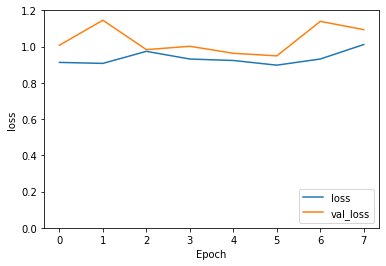

In [14]:
graph_history('loss', 'val_loss', [0.0, 1.2])

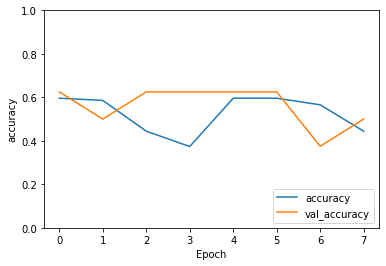

In [13]:
graph_history('accuracy', 'val_accuracy', [0.0, 1.0])